In [1]:
%env CUDA_VISIBLE_DEVICES=7
%env TOKENIZERS_PARALLELISM=false
%env WANDB_NOTEBOOK_NAME=quant.ipynb

import random

import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor

from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

from datasets import load_dataset

from tqdm.notebook import tqdm, trange

env: CUDA_VISIBLE_DEVICES=7
env: TOKENIZERS_PARALLELISM=false
env: WANDB_NOTEBOOK_NAME=quant.ipynb


In [2]:
DEVICE = "cuda"

### Simple quant

In [3]:
def get_scale_and_zero(x: Tensor, max_abs: float) -> tuple[Tensor, Tensor]:
    """ Given a tensor x of shape (m, k) and max_abs > 0 produce tensors scale and zero of shape (m, 1)
        such that 0 < x / scale + zero < max_abs"""
    # YOUR CODE HERE>>>>>>>>>
    xmin = x.min(-1)[0]
    xmax = x.max(-1)[0]

    scale = (xmax - xmin) / max_abs
    scale[scale == 0] = 1
    zero = -xmin / scale

    scale = scale.unsqueeze(-1)
    zero = zero.unsqueeze(-1)
    return scale.to(x.dtype), zero.to(x.dtype)

def quantize_simple(x, bits):
    return torch.clamp(torch.round(x), 0, 2 ** bits - 1)


### Hadamard quant

In [4]:
from functools import cache, lru_cache
import math
import numpy as np
from scipy.special import erf

# half-normal centroids
opt_hn_centroids = {
    1: [0.7978845608028654],
    2: [0.4527800398860679, 1.5104176087114887],
    3: [0.24509416307340598, 0.7560052489539643, 1.3439092613750225, 2.151945669890335],
    4: [
        0.12839501671105813,
        0.38804823445328507,
        0.6567589957631145,
        0.9423402689122875,
        1.2562309480263467,
        1.6180460517130526,
        2.069016730231837,
        2.732588804065177,
    ],
}


def section_variance(a, b, c) -> float:
    if math.isinf(c):
        return (
            np.sqrt(2 / np.pi) * np.exp(-(a**2) / 2) * (a - 2 * b)
            - (b**2 + 1) * erf(a / np.sqrt(2))
            + (b**2 + 1) * erf(c / np.sqrt(2))
        )
    else:
        return (
            np.sqrt(2 / np.pi) * np.exp(-(a**2) / 2) * (a - 2 * b)
            - (b**2 + 1) * erf(a / np.sqrt(2))
            + (b**2 + 1) * erf(c / np.sqrt(2))
            + np.sqrt(2 / np.pi) * np.exp(-(c**2) / 2) * (2 * b - c)
        )


def gen_boundaries(centroids):
    return [(a + b) / 2 for a, b in zip(centroids[:-1], centroids[1:])]


def gen_all_normal_quantization_constants():
    # add symmetric negative normal centroids
    centroids = {i: [-j for j in reversed(c)] + c for i, c in opt_hn_centroids.items()}

    # centroids to bin boundaries
    boundaries = {i: gen_boundaries(c) for i, c in centroids.items()}

    return centroids, boundaries
    

@cache
def bits_var():
    result = {0: 1}
    for bits, centers in opt_hn_centroids.items():
        borders = [0] + [(a + b) / 2 for a, b in zip(centers[:-1], centers[1:])] + [float("inf")]
        variance = sum(section_variance(a, b, c) for a, b, c in zip(borders[:-1], centers, borders[1:]))
        result[bits] = variance
    return result


@cache
def get_all_quantization_constants_tensors(device):
    centroids, boundaries = gen_all_normal_quantization_constants()

    centroids = {i: torch.tensor(c, device=device) for i, c in centroids.items()}
    boundaries = {i: torch.tensor(b, device=device) for i, b in boundaries.items()}

    return centroids, boundaries



centroids, boundaries = get_all_quantization_constants_tensors(DEVICE)

def quantize_hadamard(weight, bits):
    assignments = torch.bucketize(weight, boundaries[bits])
    return torch.take(centroids[bits], assignments)


### GPTQ

In [5]:
@torch.no_grad()
def gptq_block(block_weight: Tensor, block_hessian_inverse: Tensor, bits: int, do_hadamard: bool) -> tuple[Tensor, Tensor]:
    """Perform GPTQ within block
    Args:
        block_weight (Tensor): weight to quantize of shape (OUT, BLOCK_SIZE)
        block_hessian_inverse (Tensor): Cholesky inverse Hessian. Upper triangular of shape (BLOCK_SIZE, BLOCK_SIZE)
        bits (int): number of bits to quantize() to

    Returns:
        tuple[Tensor, Tensor]: quantized weight and scaled quantization error
    """
    quantized_block_weight = torch.zeros_like(block_weight)
    scaled_block_error = torch.zeros_like(block_weight)

    # Interate over the block's columns
    for i in range(block_weight.shape[1]):
        # Get the column and the corresponding inverse Hessian
        column_weight = block_weight[:, [i]]
        # YOUR CODE HERE>>>>>>>>>
        column_hessian_inverse = block_hessian_inverse[i, i]

        # Quantize the column weight
        if do_hadamard:
            quantized_column_weight = quantize_hadamard(column_weight.clone(), bits)
        else:
            quantized_column_weight = quantize_simple(column_weight.clone(), bits)
        quantized_block_weight[:, [i]] = quantized_column_weight.clone()
        dequantized_column_weight = quantized_column_weight

        # Update all the following columns within the block
        scaled_column_error = (column_weight - dequantized_column_weight) / column_hessian_inverse
        block_weight[:, i+1:] -= scaled_column_error.matmul(block_hessian_inverse[[i], i+1:])
        scaled_block_error[:, [i]] = scaled_column_error
        # <<<<<<<<<<<<<<<<<<<<<<<

    return quantized_block_weight, scaled_block_error, block_weight


In [6]:
from fast_hadamard_transform import hadamard_transform

BLOCK_SIZE = 1024

def prepare_inverse_hessian(hessian: Tensor, percdamp: float) -> Tensor:
    """Precomputes inverse Hessian
    Args:
        hessian (Tensor): problem hessian
        percdamp (float): diagonal damping constant for numerical stability
    Returns:
        Tensor: precomputed inverse Hessian
    """
    damp = percdamp * torch.mean(torch.diag(hessian))
    diag = torch.arange(hessian.shape[0], device=hessian.device)
    hessian[diag, diag] += damp
    hessian = torch.linalg.cholesky(hessian)
    hessian = torch.cholesky_inverse(hessian)
    hessian = torch.linalg.cholesky(hessian, upper=True)
    return hessian

def pad_to_power_of_2(tensor, dims):
    pad_dims = [0 for _ in range(2 * len(tensor.shape))]
    for dim in dims:
        size = tensor.shape[dim]
        next_power_of_2 = 2**(size-1).bit_length()
        delta = next_power_of_2 - size
        pad_dims[-2 * dim - 1] = delta
    
    return F.pad(tensor, pad_dims, "constant", 0)

def pad_to_block(tensor, dims):
    pad_dims = [0 for _ in range(2 * len(tensor.shape))]
    for dim in dims:
        size = tensor.shape[dim]
        next_multiple_of_1024 = ((size - 1) // BLOCK_SIZE + 1) * BLOCK_SIZE
        delta = next_multiple_of_1024 - size
        pad_dims[-2 * dim - 1] = delta
    
    return F.pad(tensor, pad_dims, "constant", 0)

@torch.no_grad()
def gptq(
    weight: torch.Tensor, bits: int, hessian: torch.Tensor,
    do_hadamard=True,
    blocksize:int=128, percdamp:float=.01
) -> tuple[Tensor, Tensor, Tensor]:
    """Quantizes weight with GPTQ
    Args:
        weight (torch.Tensor): weight to quantize
        bits (int): number of bits to quantize to
        hessian (torch.Tensor): problem Hessian
        blocksize (int, optional): Defaults to 128.
        percdamp (float, optional): Hessian damping constant for numerical stability. Defaults to .01.

    Returns:
        tuple[Tensor, Tensor, Tensor]: quantized_weight, row-wise quantization scales, row-wise quantization zeroes
    """

    dtype = weight.dtype
    weight = weight.float()
    num_columns = weight.shape[1]
    hessian = hessian.float()

    # Normalize
    if do_hadamard:
        # scales = torch.linalg.norm(weight, axis=-1)
        weight = pad_to_block(weight, [1])
        hessian = pad_to_block(hessian, [0, 1])
        
        mult = weight.shape[1] // BLOCK_SIZE
        weight = weight.reshape(-1, mult, BLOCK_SIZE)
        hessian = hessian.reshape(mult, BLOCK_SIZE, mult, BLOCK_SIZE)
        
        scales = torch.linalg.norm(weight, axis=-1)
        
        weight = hadamard_transform(weight) / scales[:, :, None]
        hessian = hadamard_transform(
            hadamard_transform(hessian, scale=1/np.sqrt(BLOCK_SIZE)).permute(2, 3, 0, 1),
            scale=1/np.sqrt(BLOCK_SIZE)
        ).permute(2, 3, 0, 1)
        
        weight = weight.reshape(-1, mult * BLOCK_SIZE)
        hessian = hessian.reshape(mult * BLOCK_SIZE, mult * BLOCK_SIZE)
    else:
        scales, zeros = get_scale_and_zero(weight, 2**bits - 1)
        weight = weight / scales + zeros

    # Process the Hessian to obtain the precomputed inverse Hessian
    hessian_inverse = prepare_inverse_hessian(hessian, percdamp)

    # Iterate over the columns in blockss
    quantized_weight = weight.clone()
    for block_start in range(0, num_columns, blocksize):
        # YOUR CODE HERE>>>>>>>>>
        block_end = min(block_start + blocksize, num_columns)

        # Get the next block and quantize it
        quantized_block_weight, block_error, weight[:, block_start:block_end] = gptq_block(
            weight[:, block_start:block_end],
            hessian_inverse[block_start:block_end, block_start:block_end],
            bits, do_hadamard,
        )

        # Tune all the following blocks to mitigate the quantization error
        quantized_weight[:, block_start:block_end] = quantized_block_weight.clone()
        weight[:, block_end:] -= block_error.matmul(hessian_inverse[block_start:block_end, block_end:])
        # <<<<<<<<<<<<<<<<<<<<<<<
    if do_hadamard:
        quantized_weight = (quantized_weight.reshape(quantized_weight.shape[0], -1, BLOCK_SIZE) * scales[:, :, None]).reshape(quantized_weight.shape[0], -1)
    else:
        quantized_weight = (quantized_weight - zeros) * scales
    return quantized_weight.to(dtype)


class HadLinear(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = nn.Parameter(weight/math.sqrt(BLOCK_SIZE))
    
    def forward(self, input):
        input = pad_to_block(input, [-1])
        mult = input.shape[-1] // BLOCK_SIZE
        input = input.reshape(input.shape[:-1] + (mult, BLOCK_SIZE))
        input = hadamard_transform(input, scale=1/math.sqrt(BLOCK_SIZE))
        input = input.reshape(input.shape[:-2] + (mult * BLOCK_SIZE,))
        return F.linear(input, self.weight)


In [7]:
weight = torch.load("./weight.pt").to(DEVICE)
hessian = torch.load("./hessian.pt").to(DEVICE)
inputs = torch.load("./inputs.pt")

In [8]:
normal_weight = gptq(weight, 4, hessian, do_hadamard=False)
had_weight = gptq(weight, 4, hessian, do_hadamard=True)

In [9]:
normal_error = 0
with torch.no_grad():
    for input in inputs:
        normal_error += torch.linalg.norm(F.linear(input.to(DEVICE), weight) - F.linear(input.to(DEVICE), normal_weight)).item()
normal_error

7137.40625

In [10]:
had_linear = HadLinear(had_weight)

had_error = 0
with torch.no_grad():
    for input in inputs:
        had_error += torch.linalg.norm(F.linear(input.to(DEVICE), weight) - had_linear(input.to(DEVICE))).item()
had_error

4166.28125

In [11]:
import sys
sys.path.append("./gptq")

from gptq import GPTQ
from quant import Quantizer
from hadamard import HadLinear

layer = torch.nn.Linear(weight.shape[1], weight.shape[0], bias=False, device=DEVICE, dtype=weight.dtype)
layer.weight.data = weight

gptq_processor = GPTQ(layer)
gptq_processor.quantizer = Quantizer()
gptq_processor.quantizer.configure(4)
gptq_processor.H = hessian
gptq_processor.nsamples = 1

res = gptq_processor.fasterquant(
    groupsize=BLOCK_SIZE, clip=False, baseline=False, had=True, eden=True,
)
one_quant_layer = HadLinear(layer.weight.data, BLOCK_SIZE, True, 16)

/nfs/scistore19/alistgrp/apanfero/CompressionEntropy/./gptq/hadamard.py:85: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
  assignments = torch.bucketize(weight, boundaries[bits])


time 2.70
error 2072563.75


In [12]:
one_quant_error = 0
with torch.no_grad():
    for input in inputs:
        one_quant_error += torch.linalg.norm(F.linear(input.to(DEVICE), weight) - one_quant_layer(input.to(DEVICE))).item()
one_quant_error

4141.0625

In [13]:
double_quant_layer = HadLinear(layer.weight.data, BLOCK_SIZE, True, 4)

In [14]:
double_quant_error = 0
with torch.no_grad():
    for input in inputs:
        double_quant_error += torch.linalg.norm(F.linear(input.to(DEVICE), weight) - double_quant_layer(input.to(DEVICE))).item()
double_quant_error

6741.5625

### 2 Bit

In [54]:
from e8p2 import QUIP_SHARP_QUANTIZER_2

In [55]:
with torch.no_grad():
    x = torch.empty((1024, 8), device=DEVICE).normal_()
    dequant = QUIP_SHARP_QUANTIZER_2.quantize(x, return_idx=False)
    quip_sharp_2_mse = (x - dequant).pow(2).mean().item()
    eden_2_mse = (x - quantize_hadamard(x, 2)).pow(2).mean().item()

In [56]:
EDEN2_GRID_2 = torch.from_numpy(np.load("EDEN2-2.npy")).to(torch.float32).cuda()
EDEN2_GRID_2_NORM = torch.linalg.norm(EDEN2_GRID_2, dim=-1)**2

In [57]:
with torch.no_grad():
    x = torch.empty((1024, 2), device=DEVICE).normal_()
    idx = torch.argmax(2 * x @ EDEN2_GRID_2.T - EDEN2_GRID_2_NORM, dim=-1)
    dequant = EDEN2_GRID_2[idx]
    eden2_2_mse = (x - dequant).pow(2).mean().item()
    

In [58]:
EDEN3_GRID_2 = torch.from_numpy(np.load("EDEN3-2.npy")).to(torch.float32).cuda()
EDEN3_GRID_2_NORM = torch.linalg.norm(EDEN3_GRID_2, dim=-1)**2

In [59]:
with torch.no_grad():
    x = torch.empty((1024, 3), device=DEVICE).normal_()
    idx = torch.argmax(2 * x @ EDEN3_GRID_2.T - EDEN3_GRID_2_NORM, dim=-1)
    dequant = EDEN3_GRID_2[idx]
    eden3_2_mse = (x - dequant).pow(2).mean().item()
    

### 3 Bit

In [60]:
from e8p3 import QUIP_SHARP_QUANTIZER_3

In [61]:
with torch.no_grad():
    x = torch.empty((1024, 8), device=DEVICE).normal_()
    dequant = QUIP_SHARP_QUANTIZER_3.quantize(x, return_idx=False)
    quip_sharp_3_mse = (x - dequant).pow(2).mean().item()
    eden_3_mse = (x - quantize_hadamard(x, 3)).pow(2).mean().item()

In [62]:
EDEN2_GRID_3 = torch.from_numpy(np.load("EDEN2-3.npy")).to(torch.float32).cuda()
EDEN2_GRID_3_NORM = torch.linalg.norm(EDEN2_GRID_3, dim=-1)**2

In [63]:
with torch.no_grad():
    x = torch.empty((1024, 2), device=DEVICE).normal_()
    idx = torch.argmax(2 * x @ EDEN2_GRID_3.T - EDEN2_GRID_3_NORM, dim=-1)
    dequant = EDEN2_GRID_3[idx]
    eden2_3_mse = (x - dequant).pow(2).mean().item()
    

In [64]:
EDEN3_GRID_3 = torch.from_numpy(np.load("EDEN3-3.npy")).to(torch.float32).cuda()
EDEN3_GRID_3_NORM = torch.linalg.norm(EDEN3_GRID_3, dim=-1)**2

In [65]:
with torch.no_grad():
    x = torch.empty((1024, 3), device=DEVICE).normal_()
    idx = torch.argmax(2 * x @ EDEN3_GRID_3.T - EDEN3_GRID_3_NORM, dim=-1)
    dequant = EDEN3_GRID_3[idx]
    eden3_3_mse = (x - dequant).pow(2).mean().item()
    

### 4 Bit

In [66]:
from e8p4 import QUIP_SHARP_QUANTIZER_4

In [67]:
with torch.no_grad():
    x = torch.empty((1024, 8), device=DEVICE).normal_()
    dequant = QUIP_SHARP_QUANTIZER_4.quantize(x, return_idx=False)
    quip_sharp_4_mse = (x - dequant).pow(2).mean().item()
    eden_4_mse = (x - quantize_hadamard(x, 4)).pow(2).mean().item()

In [68]:
EDEN2_GRID_4 = torch.from_numpy(np.load("EDEN2-4.npy")).to(torch.float32).cuda()
EDEN2_GRID_4_NORM = torch.linalg.norm(EDEN2_GRID_4, dim=-1)**2

In [69]:
with torch.no_grad():
    x = torch.empty((1024, 2), device=DEVICE).normal_()
    idx = torch.argmax(2 * x @ EDEN2_GRID_4.T - EDEN2_GRID_4_NORM, dim=-1)
    dequant = EDEN2_GRID_4[idx]
    eden2_4_mse = (x - dequant).pow(2).mean().item()
    

### Plots

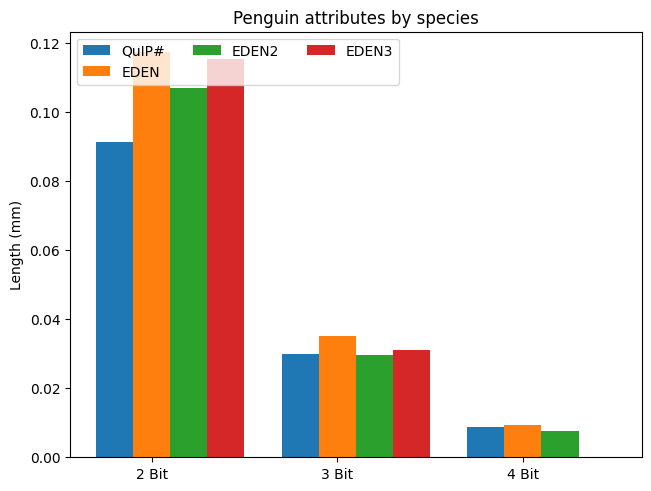

In [70]:
import matplotlib.pyplot as plt
import numpy as np

species = ("2 Bit", "3 Bit", "4 Bit")
penguin_means = {
    'QuIP#': (quip_sharp_2_mse, quip_sharp_3_mse, quip_sharp_4_mse),
    'EDEN': (eden_2_mse, eden_3_mse, eden_4_mse),
    'EDEN2': (eden2_2_mse, eden2_3_mse, eden2_4_mse),
    'EDEN3': (eden3_2_mse, eden3_3_mse, 0),
}

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)

plt.show()